# 프로젝트: 베트남 음식 분류하기

데이터는 30VNFoods라는 데이터로 30가지 베트남 음식 이미지를 모아놓은 것

여기에서는 30종류의 베트남 음식 중 10개의 카테고리를 선별해서 실습을 진행

In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# training set과 test set의 모든 이미지 파일에 대해서,
# jpg image header가 포함되지 않은 (jpg의 파일 구조에 어긋나는) 파일들을 삭제해줍니다.

data_path = '/aiffel/aiffel/model-fit/data/30vnfoods/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'

# for path in [train_path, test_path]:
#     classes = os.listdir(path)

#     for food in classes:
#         food_path = os.path.join(path, food)
#         images = os.listdir(food_path)
        
#         for image in images:
#             with open(os.path.join(food_path, image), 'rb') as f:
#                 bytes = f.read()
#             if bytes[:3] != b'\xff\xd8\xff':
#                 print(os.path.join(food_path, image))
#                 os.remove(os.path.join(food_path, image))

In [3]:
classes = os.listdir(train_path)
train_length = 0

for food in classes:
    food_path = os.path.join(train_path, food)
    images = os.listdir(food_path)
    
    train_length += len(images)

print('training data의 개수: '+str(train_length))

training data의 개수: 9775


# 문제1: dataloader 구현하기
주어진 함수들과 TensorFlow Data API를 이용해서 dataloader를 구현해야 합니다.

In [4]:
!pip3 install tensorflow-estimator==2.6.0

     |████████████████████████████████| 462 kB 7.2 MB/s            
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.


In [5]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label



def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title().split('/')[-1])
        plt.imshow(image_batch[n])
    plt.show()
    

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

Find 10 class : ['/aiffel/aiffel/model-fit/data/30vnfoods/Train/Bun dau mam tom', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Banh cuon', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Pho', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Bun bo Hue', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Banh xeo', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Banh khot', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Com tam', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Banh mi', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Chao long', '/aiffel/aiffel/model-fit/data/30vnfoods/Train/Bun rieu']


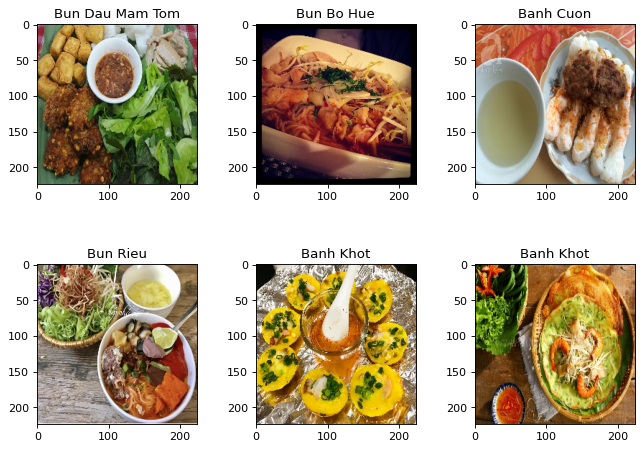

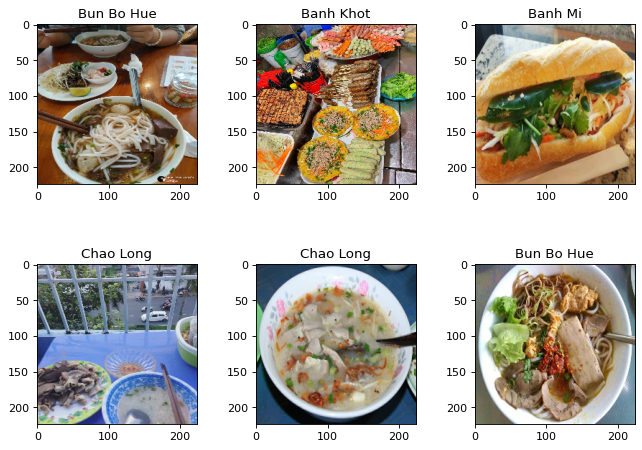

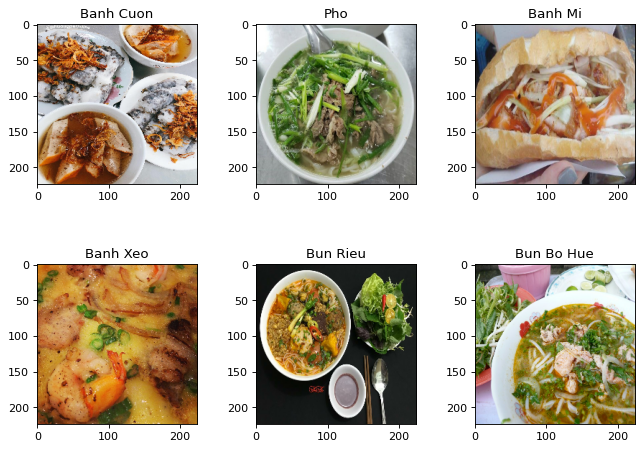

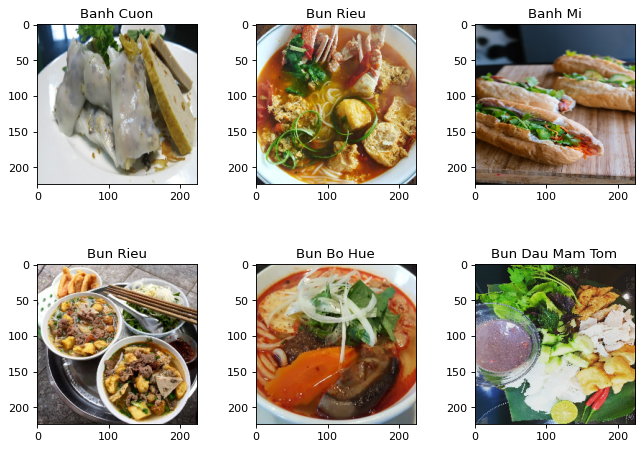

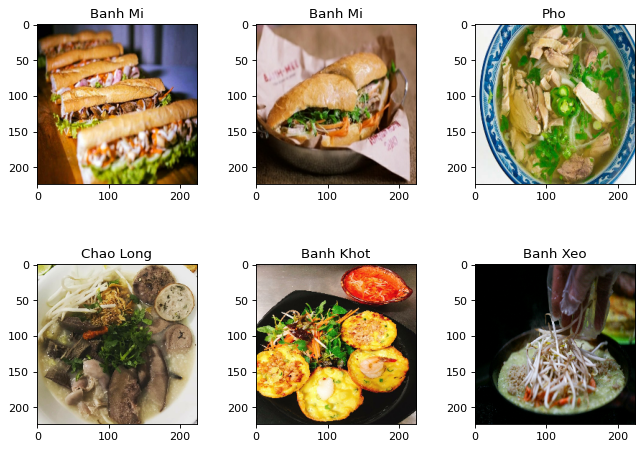

In [6]:
data_path = '/aiffel/aiffel/model-fit/data/30vnfoods/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'
train_dataset = load_data(train_path, batch_size=6)
data_dir = pathlib.Path(train_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

# 문제2: 모델 구현하기
EfficientNetB0 backbone과 Dense 레이어를 결합하여 모델을 구현해야 합니다.
다른 모델을 사용하여 backbone을 만들어 보아도 좋습니다.

In [7]:
from tensorflow.keras.applications import EfficientNetB0

class VietnamFood(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 갯수 만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=10, freeze=False):
        super(VietnamFood, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        if freeze:
            self.base_model.trainable = False
        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dropout(0.5, name="top_dropout")])
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")
    def call(self, inputs, training=True):
        x = self.base_model(inputs)
        x = self.top(x)
        x = self.classifier(x)
        return x

if __name__ == '__main__':
    model = VietnamFood(num_classes=10, freeze=True)
    model.build(input_shape=(None, 224, 224, 3))
    print(model.summary())

16719872/16705208 [==============================] - 0s 0us/step
Model: "vietnam_food"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
sequential (Sequential)      (None, 1280)              5120      
_________________________________________________________________
pred (Dense)                 multiple                  12810     
Total params: 4,067,501
Trainable params: 15,370
Non-trainable params: 4,052,131
_________________________________________________________________
None


# 문제3: custom trainer 구현하기
TensorFlow GradientTape를 이용해서 custom trainer 클래스를 구현해야 합니다.
학습이 진행되면서 training accuracy가 점차 증가할 수 있도록 만들어 보세요.

In [8]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # 매 batch 마다 반복적으로 학습
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # train metric 업데이트
                train_metric.update_state(y_batch_train, logits)
                # 5 배치마다 로깅
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # 마지막 epoch 학습이 끝나면 train 결과를 보여줌
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

In [ ]:
# 모델 학습 코드

train_path = "/aiffel/aiffel/model-fit/data/30vnfoods/Train"

epoch = 5
batch = 32

model = VietnamFood(num_classes=10)
dataset = load_data(data_path=train_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                epochs=epoch,
                batch=batch,
                loss_fn=loss_function,
                optimizer=optimizer)

trainer.train(train_dataset=dataset,
            train_metric=train_acc_metric)


Start of epoch 0
Training loss (for one batch) at step 0: 3.7151
Seen so far: 32 samples
0.09375
Training loss (for one batch) at step 5: 2.8150
Seen so far: 192 samples
0.15104167
Training loss (for one batch) at step 10: 2.1659
Seen so far: 352 samples
0.23295455
Training loss (for one batch) at step 15: 1.7793
Seen so far: 512 samples
0.28515625
Training loss (for one batch) at step 20: 1.6097
Seen so far: 672 samples
0.3392857
Training loss (for one batch) at step 25: 1.5027
Seen so far: 832 samples
0.37019232
Training loss (for one batch) at step 30: 1.3417
Seen so far: 992 samples
0.40423387
Training loss (for one batch) at step 35: 1.9659
Seen so far: 1152 samples
0.4236111
Training loss (for one batch) at step 40: 1.8784
Seen so far: 1312 samples
0.4496951
Training loss (for one batch) at step 45: 1.2921
Seen so far: 1472 samples
0.47350544
Training loss (for one batch) at step 50: 1.0209
Seen so far: 1632 samples
0.48958334
Training loss (for one batch) at step 55: 0.8312
See

In [ ]:
# 모델 테스트 코드

test_ds = load_data(data_path=test_path)

for step_train, (x_batch_train, y_batch_train) in enumerate(test_ds.take(10)):
    prediction = model(x_batch_train)
    print("{}/{}".format(np.array(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1))).sum(), tf.argmax(y_batch_train, axis=1).shape[0]))

## 결과 분석 :

# 회고
잘한 점 : 새로운 방식으로 모델을 적용해보았다. 특히 데이터를 알맞게 불러오고 필요에 맞게 모델을 훈련시킬 수 있는 점에서 활용도가 높아보인다.

못한 점 : 프로젝트 노드에서는 모델 훈련에 소요되는 시간이 약 9분이라고 하였는데, 나의 프로젝트의 경우 3시간 이상 소요되었다. 이것의 원인을 모른채 마무리하였다.

노력할 점 : 모델 훈련시간이 오래걸린 이유에 대해 고민해보고 보완할 점을 찾아봐야겠다.
